## Imports

In [14]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError

from extraction.extract import *
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, normalize
%load_ext tensorboard
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Settings

In [15]:
airport = "EGLL"
timeslotLength = 30

start = datetime(2018, 3, 1)
end = datetime(2019, 1, 1)
timeslotLength = 30

batch_size = 256
epochs = 1000
patience = 100
lookback = 4 * int(60/timeslotLength)

lookahead = 3 * int(60/timeslotLength)
multi_horizon = True

learning_rate = 0.0001 

runName = "lstmv1"
saveModel = True
loadModel = False
modelSaveFolder = "LSTMModels/"
modelSaveLocation = modelSaveFolder + runName

#### Load Data

In [16]:
dataset = generateNNdata(airport = airport, timeslotLength=timeslotLength, start=start, end=end, GNNFormat=True)
# print(dataset)

columnsToDrop = [
    "weekend",
    "winter",
    "spring",
    "summer",
    "autumn",
    "night",
    "morning",
    "afternoon",
    "evening",
    "planes",
    "arrivalsDepartureDelay"
]


Xfull, Yfull, Tfull = dataset[0], dataset[1], dataset[2]
Xfull = Xfull.drop(columnsToDrop, axis=1)

Xarray, Yarray = pd.concat((Xfull, Yfull), axis=1), Yfull.to_numpy()
print(Xarray.columns)
Xarray = Xarray.to_numpy()
nFeatures = Xarray.shape[1]
nLabels = Yarray.shape[1]

#scale
scaler = MinMaxScaler(feature_range=(0, 1))
Xarray = scaler.fit_transform(Xarray)
times = Tfull

print(times)

Index(['departing', 'arriving', 'lowcost', 'arrivalsFlightDuration',
       'departuresFlightDuration', 'capacityFilled', 'arrivalsArrivalDelay',
       'departuresDepartureDelay'],
      dtype='object')
                timeslot
0    2018-03-01 00:00:00
1    2018-03-01 00:30:00
2    2018-03-01 01:00:00
3    2018-03-01 01:30:00
4    2018-03-01 02:00:00
...                  ...
5851 2018-12-31 21:30:00
5852 2018-12-31 22:00:00
5853 2018-12-31 22:30:00
5854 2018-12-31 23:00:00
5855 2018-12-31 23:30:00

[5856 rows x 1 columns]


In [17]:
train_split, val_split = 0.6, 0.25
fullLength = len(Xfull)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(
    f"Train split: {0}:{train_idx} | Validation split: {train_idx}:{val_idx} | Test split: {val_idx}:{fullLength}"
)

# generate raw splits
Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]

# Save test timeslots for plotting purposes
testTimes = times.iloc[val_idx::, 0].tolist()


Train split: 0:3513 | Validation split: 3513:4977 | Test split: 4977:5856


#### Create Dataset

In [18]:
def create_tf_dataset(
    data_array: np.ndarray,
    target_array,
    lookback: int,
    lookahead: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, lookback, num_routes, 1)` containing
    the `lookback` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, lookahead, num_routes)`
    containing the `lookahead`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        lookback: Length of the input sequence (in number of timesteps).
        lookahead: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `lookahead` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `lookahead` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `lookahead`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        data_array[:-lookahead],
        None,
        sequence_length=lookback,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = inputs
    target_offset = (
        lookback
        if multi_horizon
        else lookback + lookahead - 1
    )
    target_seq_length = lookahead if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)
    print(dataset)
    return dataset.prefetch(16).cache()#.batch(64, drop_remainder=True)#


train_dataset = create_tf_dataset(
    Xtrain,
    Ytrain,
    lookback,
    lookahead,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

val_dataset = create_tf_dataset(
    Xval,
    Yval,
    lookback,
    lookahead,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)
test_dataset = create_tf_dataset(
    Xtest,
    Ytest,
    lookback,
    lookahead,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

print(train_dataset)


<ZipDataset shapes: ((None, None, 8), (None, None, 2)), types: (tf.float64, tf.float64)>
<ZipDataset shapes: ((None, None, 8), (None, None, 2)), types: (tf.float64, tf.float64)>
<ZipDataset shapes: ((None, None, 8), (None, None, 2)), types: (tf.float64, tf.float64)>
<CacheDataset shapes: ((None, None, 8), (None, None, 2)), types: (tf.float64, tf.float64)>


#### Model

In [19]:
# model = Sequential()
# model.add(layers.LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(layers.Dropout(0.25))
# model.add(layers.LSTM(400, return_sequences=True))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(50))
# model.add(layers.LSTM(800, return_sequences=True))
# model.add(layers.Dense(50))
# model.add(layers.LSTM(300))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(25))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(10))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(2))
# model.compile(loss='mae', optimizer='adam')
# model.summary()

# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=0, shuffle=False)


In [20]:
inputs = layers.Input((lookback, nFeatures))#, batch_size=batch_size)
lstm1 = layers.LSTM(200, return_sequences=True)
lstm2 = layers.LSTM(200, return_sequences=False)
dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.25)
dense2 = layers.Dense(100)
output = layers.Dense(lookahead*nLabels)
reshape = layers.Reshape((lookahead, nLabels))

out = lstm1(inputs)
out = lstm2(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
outputs = output(out)
# outputs = tf.reshape(outputs, (batch_size, lookahead, nLabels))
outputs = reshape(outputs)

model = keras.models.Model(inputs, outputs)

optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 8, 200)            167200    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 12)                1212

In [21]:
if not loadModel:
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(
    #     log_dir=log_dir, histogram_freq=1
    # )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=patience),
            # tensorboard_callback,
        ],
    )


Epoch 1/1000
14/14 [==============================] - 5s 87ms/step - loss: 158.5922 - acc: 0.6154 - val_loss: 179.0316 - val_acc: 0.9052
Epoch 2/1000
14/14 [==============================] - 0s 18ms/step - loss: 155.0017 - acc: 0.9167 - val_loss: 173.0218 - val_acc: 0.9586
Epoch 3/1000
14/14 [==============================] - 0s 17ms/step - loss: 144.7094 - acc: 0.9439 - val_loss: 152.9807 - val_acc: 0.9586
Epoch 4/1000
14/14 [==============================] - 0s 25ms/step - loss: 113.8602 - acc: 0.9454 - val_loss: 106.9114 - val_acc: 0.9586
Epoch 5/1000
14/14 [==============================] - 0s 20ms/step - loss: 84.4518 - acc: 0.9454 - val_loss: 95.4359 - val_acc: 0.9586
Epoch 6/1000
14/14 [==============================] - 0s 25ms/step - loss: 75.9322 - acc: 0.9454 - val_loss: 90.4530 - val_acc: 0.9586
Epoch 7/1000
14/14 [==============================] - 0s 21ms/step - loss: 73.2650 - acc: 0.9454 - val_loss: 87.1010 - val_acc: 0.9586
Epoch 8/1000
14/14 [===========================

In [22]:
if saveModel and not loadModel:
    model.save(modelSaveLocation)
elif saveModel and loadModel:
    raise Exception(
        "You have enabled both loading and saving, which are incompatible. Model has not been saved"
    )

INFO:tensorflow:Assets written to: LSTMModels/lstmv1\assets


INFO:tensorflow:Assets written to: LSTMModels/lstmv1\assets


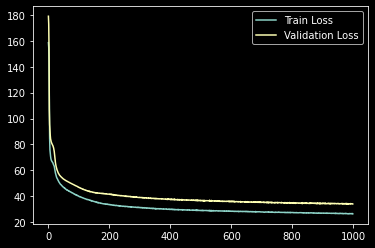

In [23]:
if not loadModel:
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

In [24]:
windowSize = 200  # 1-400

forecastlen = 10  # 1-10
forecastlen = min(forecastlen, lookahead)
print(f"Hours ahead = {forecastlen / (60/timeslotLength)}")


Hours ahead = 3.0


[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
[1, 2, 3, 4, 5, 6]
[6.092920623100299, 6.7344606815928945, 7.3790218582603435, 8.176992171224281, 8.94671803770129, 9.428379656225273]


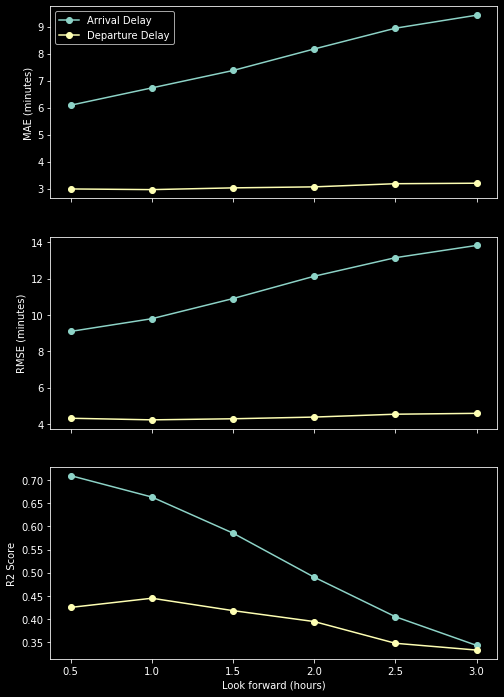

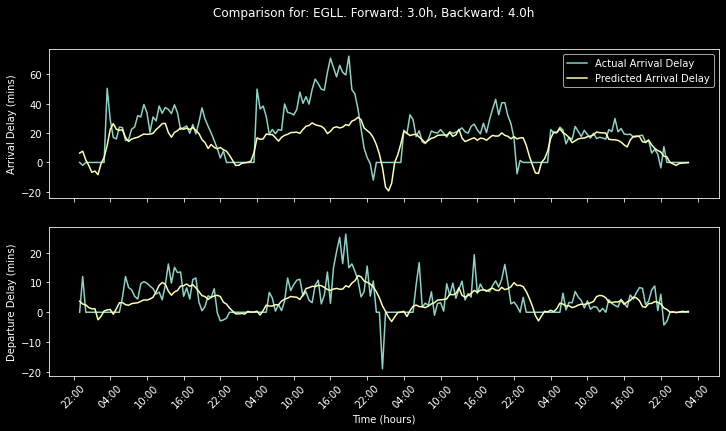

In [25]:
def getLabelArrays(hour, input_sequence_length=lookback):
    syncindex = input_sequence_length + hour - 1
    yTestPred = model.predict(test_dataset, verbose=0)
    ypredFull = yTestPred[:windowSize, hour - 1, :]
    yactualFull = Ytest[syncindex : windowSize + syncindex :, :]

    mae1 = mean_absolute_error(yactualFull[:, 0], ypredFull[:, 0])
    mae2 = mean_absolute_error(yactualFull[:, 1], ypredFull[:, 1])
    rmse1 = np.sqrt(mean_squared_error(ypredFull[:, 0], yactualFull[:, 0],))
    rmse2 = np.sqrt(mean_squared_error(ypredFull[:, 1], yactualFull[:, 1],))
    r2_1 = r2_score(yactualFull[:, 0], ypredFull[:, 0])
    r2_2 = r2_score(yactualFull[:, 1], ypredFull[:, 1])

    time = testTimes[syncindex : windowSize + syncindex :]
    return ypredFull, yactualFull, mae1, mae2, rmse1, rmse2, r2_1, r2_2, time


def plotComparison(hour):
    ypredFull, yactualFull, _, _, _, _, _, _, time = getLabelArrays(hour)
    fig, axs = plt.subplots(2, 1, sharex=True, num=32)
    axs[0].plot(
        time, yactualFull[:, 0], label="Actual Arrival Delay"
    )
    axs[1].plot(time, yactualFull[:, 1], label="Actual Departure Delay")
    axs[0].plot(
        time, ypredFull[:, 0], label="Predicted Arrival Delay"
    )
    axs[1].plot(time, ypredFull[:, 1], label="Predicted Departure Delay")
    axs[0].legend()
    # axs[1].legend()
    axs[1].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Arrival Delay (mins)")
    axs[1].set_ylabel("Departure Delay (mins)")
    plt.suptitle(
        f"Comparison for: {airport}. Forward: {hour / (60/timeslotLength)}h, Backward: {lookback / (60/timeslotLength)}h"
    )
    axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.xticks(rotation=45)
    fig.set_figwidth(12)
    fig.set_figheight(6)


def plotErrorVsLookback(forecast_horizon=forecastlen):
    fig2, axss = plt.subplots(3, 1, sharex=True, num=100)
    lookforwardss = list(range(1, forecast_horizon + 1))
    hours = [x/(60/timeslotLength) for x in range(1, forecast_horizon+1)]
    print(hours)
    print(lookforwardss)
    maeList = []
    maeList2 = []
    rmseList = []
    rmseList2 = []
    r2List = []
    r2List2 = []

    for h in lookforwardss:
        _, _, mae1, mae2, rmse1, rmse2, r2_1, r2_2, _ = getLabelArrays(h)
        maeList.append(mae1)
        maeList2.append(mae2)
        rmseList.append(rmse1)
        rmseList2.append(rmse2)
        r2List.append(r2_1)
        r2List2.append(r2_2)
    print(maeList)
    axss[0].plot(hours, maeList, label = "Arrival Delay", marker="o")
    axss[0].plot(hours, maeList2, label = "Departure Delay", marker="o")
    axss[1].plot(hours, rmseList, label = "Arrival Delay", marker="o")
    axss[1].plot(hours, rmseList2, label = "Departure Delay", marker="o")
    axss[2].plot(hours, r2List, label = "Arrival Delay", marker="o")
    axss[2].plot(hours, r2List2, label = "Departure Delay", marker="o")

    axss[0].set_ylabel("MAE (minutes)")
    axss[1].set_ylabel("RMSE (minutes)")
    axss[2].set_ylabel("R2 Score")
    # axss[0].grid()
    # axss[1].grid()
    # axss[2].grid()

    axss[2].set_xlabel("Look forward (hours)")

    axss[0].legend()

    fig2.set_figwidth(8)
    fig2.set_figheight(12)

plotErrorVsLookback()
plt.show()

plotComparison(forecastlen)
# for airportidx in range(0, int(len(airports)/5)):
# # plt.show()